In [1]:
# Run from command line by:
# jupyter nbconvert --ExecutePreprocessor.timeout=600 --to notebook --execute sar_nlp_prep.ipynb --output sar_nlp_prep_out.ipynb
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy
from sklearn import metrics


from fastai import *
from fastai.datasets import *
from fastai.text import *

## Preprocessing function to split into tags and doc

In [3]:
def split_into_tags_and_doc(tweet):
    tweet = tweet.replace("@Hordalandpoliti", "") # in old twitter account tweets
    tag_list = re.findall("#(\w+)", tweet)
    for tag in tag_list:
        tweet = tweet.replace("#" + tag, "")
    return "|".join(tag_list), re.sub("^[\W0-9]*", "", tweet)  # remove leading non-text

# Test this on a few tweets:
tweets = [
    "@Hordalandpoliti Det er stadfesta at personen har vore åleine ombord. Redningsaksjonen vert avslutta.",
    "Fv 562 ved #Åsebø på #Askøy kl. 1920. Ein stor stein, tippa til rundt 100 kg, hadde rase ned i vegen. Ein bil køyrde på denne. Ikkje personskade, men marerielle skadar på bilen. Politiet har vore på staden, og entreprenør har rydda vegen.",
    "Politiet på stedet. Bilen er fjernet. Trafikken flyter som normalt.",
    "#Moskogen, E39. Meld om trafikkuhell. Ein bil involvert. Ikkje meld om personskade. Politiet på veg til staden.",
    "#Nordfjord,#Stryn, #Langeset, #RV15 Meldt om trafikkulykke, personbil som har kjørt inn i vogntog. Fører av personbilen er bevisst. Det er glatt veibane, store trafikale problemer."
]
for tweet in tweets:
    tag_list, doc = split_into_tags_and_doc(tweet)
    print(tag_list, "--", doc)

 -- Det er stadfesta at personen har vore åleine ombord. Redningsaksjonen vert avslutta.
Åsebø|Askøy -- Fv 562 ved  på  kl. 1920. Ein stor stein, tippa til rundt 100 kg, hadde rase ned i vegen. Ein bil køyrde på denne. Ikkje personskade, men marerielle skadar på bilen. Politiet har vore på staden, og entreprenør har rydda vegen.
 -- Politiet på stedet. Bilen er fjernet. Trafikken flyter som normalt.
Moskogen -- E39. Meld om trafikkuhell. Ein bil involvert. Ikkje meld om personskade. Politiet på veg til staden.
Nordfjord|Stryn|Langeset|RV15 -- Meldt om trafikkulykke, personbil som har kjørt inn i vogntog. Fører av personbilen er bevisst. Det er glatt veibane, store trafikale problemer.


## Read data and preprocess

In [4]:
xlsx_name = r"..\data\raw\vicinitas_user_tweets_vest_scoring_layout.xlsx"

In [5]:
df_xlsx = pd.read_excel(xlsx_name,
                        sheet_name="tweets",
                        header=0,
                        usecols=["i_man", "i_alg", "Text"],
                        dtype= {"Text": str, "i_man": np.float32})  # float to accomodate nan
df_xlsx.dropna(inplace=True)  # in practice: drop rows without an i_man label
df_xlsx.drop(df_xlsx[df_xlsx["i_alg"] == 0].index, inplace=True)
df_xlsx = df_xlsx.astype({"i_man": np.int8})
df_xlsx["tags"], df_xlsx["doc"] = zip(*df_xlsx["Text"].map(split_into_tags_and_doc))
df_xlsx.drop(columns="Text", inplace=True)

In [6]:
df_xlsx.tail()

,i_man,i_alg,tags,doc
9338,0,0.111111,Bergen|Nygårdsbroen,Bilen er borte fra stedet. Fri ferdsel.
9382,0,0.023256,Askøy|Ask,Melder ser ein person som går inn i vedskjulet...
9430,0,0.055556,,Den skadde har blitt fraktet vekk fra stedet m...
9467,1,0.034483,Bergen,Byfjorden. Meldt om båt som går i ring ved Heg...
9469,0,0.043478,,Oppdatering: RV52 blir stengt en periode i for...


In [7]:
print(f"Total number of tweets: {len(df_xlsx):5}")
print(f"Positive fraction:      {100 * df_xlsx.mean()['i_man']:5.1f}%")

Total number of tweets:   819
Positive fraction:       50.1%


Create the FastAI datastructure.

In [8]:
tweets = (TextList.from_df(df_xlsx, cols='doc')
          .split_by_rand_pct(seed=42)
          .label_from_df(cols=0))

## Explore the created data structure

In [9]:
# Display a single tweet and its category (0: not interesting, 1: interesting).
tweets.x[101], tweets.y[101]

(Text xxbos xxmaj gutten er kommet til rette . https : / / t.co / xxunk,
 Category 1)

In [10]:
trn = pd.value_counts(tweets.train.y.items, sort=False)
val = pd.value_counts(tweets.valid.y.items, sort=False)
print(f"""Number of items per category and data set:
      |   0   |   1   |   sum
------+-------+-------+-------
train |{trn[0]:6} |{trn[1]:6} |{sum(trn):6}
valid |{val[0]:6} |{val[1]:6} |{sum(val):6}
""")

Number of items per category and data set:
      |   0   |   1   |   sum
------+-------+-------+-------
train |   332 |   324 |   656
valid |    77 |    86 |   163



In [11]:
print(f"Number of tokens represented:     {len(tweets.vocab.itos):5}\n"
      f"Number of words in original data: {len(tweets.vocab.stoi):5}")

Number of tokens represented:       800
Number of words in original data:  3292


In [12]:
# What are the "unknown" words?
unknown = [w for w in tweets.vocab.stoi.keys() if tweets.vocab.stoi[w] == 0]
print(unknown[:100])
print("\n\nOBS: This has several words that occur in the description of missing subjects!!!")

['xxunk', 'chihuahua', 'hann', 'kremhvit', 'joker', 'butikken', 'ikledd', 'rødt', 'hundedekken', 'overbitt', 'fleire', 'stadfesta', 'åleine', 'avslutta', 'katt', 'lodden', 'skansen', 'tjeldstø', 'seaking', '0034', 'bygning', 'tyssedal', 'sjekket', 'tyske', 'turstier', 'disponerte', 'akt', 'svartefjorden', 'fana', 'myrdalsvegen', 'elektrisk', 'rullestol', 'slik', 'bruker', 'får', '0048', 'kastet', 'brostein', 'leilighet', 'erkjent', '0224', 'siktet', 'melkeplassen', 'fauskanger', 'n.askøy', 'campingbil', 'fjellveggen', 'tilsees', 'opplyste', 'sovnet', 'ibsens', '85', 'klesdrakt', 'tynt', 'lengde', 'halsen', 'bekledning', 'knapper', 'meldingar', 'lause', 'hestar', 'e16', 'savnar', 'åsheimsvegen', 'hester', 'ville', 'vegar', 'eigaren', '21', 'vidden', 'kurs', 'kommunikasjon', 'underveis', 'arnanipatunnelen', 'songstadtunnelen', 'køer', 'løses', 'danmarksplass', 'spebygd', 'kari', 'traa', 'ullundertrøye', 'stemmevatnet', 'stemmevannet', 'haukelitunnelen', 'mannleg', 'gravid', 'mogleg', 'st

In [13]:
# What are the most frequent tokens?
tweets.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'i',
 ',',
 'er',
 'på',
 'og',
 'har',
 'til',
 'en',
 'av',
 'med']

In [14]:
# In the document-term matrix creation we use the Counter class. It resembles a dict mapping token ids
# to the number of times the token has occurred in a document. Example:
Counter(tweets.train.x[0].data)

Counter({2: 1,
         34: 1,
         625: 1,
         9: 4,
         5: 5,
         0: 5,
         11: 5,
         429: 1,
         626: 1,
         113: 1,
         366: 1,
         501: 1,
         627: 1,
         207: 1,
         71: 1,
         13: 1,
         172: 1,
         367: 1})

In [15]:
def get_doc_term_matrix(label_list, vocab_len):
    j_indices = []
    indptr = []
    values = []
    indptr.append(0)

    for i, doc in enumerate(label_list):
        feature_counter = Counter(doc.data)
        j_indices.extend(feature_counter.keys())
        values.extend(feature_counter.values())
        indptr.append(len(j_indices))
        
#     return (values, j_indices, indptr)

    return scipy.sparse.csr_matrix((values, j_indices, indptr),
                                   shape=(len(indptr) - 1, vocab_len),
                                   dtype=int)

In [16]:
%%time
doc_term_train = get_doc_term_matrix(tweets.train.x, len(tweets.vocab.itos))
doc_term_valid = get_doc_term_matrix(tweets.valid.x, len(tweets.vocab.itos))

Wall time: 42 ms


In [17]:
doc_term_train.shape, doc_term_valid.shape

((656, 800), (163, 800))

In [18]:
x_train = doc_term_train
y_train = tweets.train.y
y_valid = tweets.valid.y

In [19]:
tweets.y.classes

[0, 1]

## Log-count ratio

In [20]:
positive = 1
negative = 0

p1 = np.squeeze(np.asarray(x_train[y_train.items==positive].sum(0)))
p0 = np.squeeze(np.asarray(x_train[y_train.items==negative].sum(0)))

pr1 = (p1+1) / ((y_train.items==positive).sum() + 1)
pr0 = (p0+1) / ((y_train.items==negative).sum() + 1)

r = np.log(pr1/pr0); r

array([-0.30498 ,  0.024317,  0.      ,  0.024317, ...,  0.024317,  0.024317,  0.024317,  0.024317])

In [21]:
biggest = np.argpartition(r, -10)[-10:]
smallest = np.argpartition(r, 10)[:10]

In [22]:
print("Terms with highest scores:")
[(tweets.vocab.itos[k], k) for k in biggest]

Terms with highest scores:


[('fast', 234),
 ('hår', 107),
 ('redningsaksjonen', 208),
 ('redningsaksjon', 90),
 ('kors', 49),
 ('fjellet', 74),
 ('sakna', 178),
 ('avsluttes', 184),
 ('leteaksjon', 201),
 ('røde', 48)]

Note the double entries "savnede"/"saknet" and "redningsaksjon"/"redningsaksjonen". The second would go away with stemming, the first with a translation to only bokmål words.

In [23]:
(y_train.items==positive).mean(), (y_train.items==negative).mean()

(0.49390243902439024, 0.5060975609756098)

In [24]:
# Defined differently from fastai-course notebook to make it clear what is done. Gives same value.
b = np.log(np.count_nonzero(y_train.items==positive)/ np.count_nonzero(y_train.items==negative))

In [25]:
pred_train = (doc_term_train @ r + b) > 0
pred_valid = (doc_term_valid @ r + b) > 0

In [26]:
(pred_train == y_train.items).mean(), (pred_valid == y_valid.items).mean()

(0.9359756097560976, 0.8834355828220859)

In [27]:
def print_confusion_matrix(y_true, y_pred):
    print(pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

print_confusion_matrix(y_valid.items, pred_valid)

Predicted  False  True  All
Actual                     
0             76     1   77
1             18    68   86
All           94    69  163


In [28]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))
prob_valid = [sigmoid(x) for x in doc_term_valid @ r + b]
fpr, tpr, thresholds = metrics.roc_curve(y_valid.items, prob_valid)
roc_auc = metrics.auc(fpr, tpr)

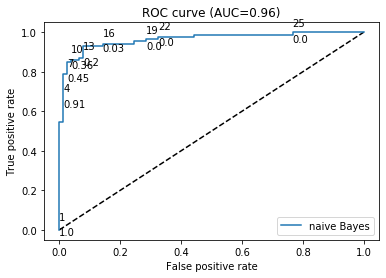

In [29]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='naive Bayes')
for i in range(1, len(fpr), 3):
    x, y, val = fpr[i], tpr[i], thresholds[i]
    plt.annotate(np.round(val, 2), (x, y-0.04))
    plt.annotate(i, (x, y+0.04))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve (AUC={roc_auc:4.2f})')
plt.legend(loc='best')
plt.show()

Based on the above, we choose threshold = 0.08; any prediction higher than that is considered positive.

In [30]:
threshold = 0.08

for tt in [0.5, threshold]:
    pred = np.array(prob_valid) > tt
    print(f"Threshold: {tt:4.2}")
    print(f"f1-score: {metrics.f1_score(y_valid.items, pred):5.3f}")
    print_confusion_matrix(y_valid.items, pred)
    print()

Threshold:  0.5
f1-score: 0.877
Predicted  False  True  All
Actual                     
0             76     1   77
1             18    68   86
All           94    69  163

Threshold: 0.08
f1-score: 0.930
Predicted  False  True  All
Actual                     
0             71     6   77
1              6    80   86
All           77    86  163



In [31]:
# Check out which texts were wrongly diagnosed in the validation set.
# Unfortunately the unmangled texts seem to no longer be available, and since the train/test split is done
# within the fastai data structure, we cannot get back to the dataframe indices.

counter = 0
for i in range(len(tweets.valid.x)):
    if bool(y_valid.items[i]) != bool(prob_valid[i] > threshold):
        counter += 1
        print(f"{counter:3}) expected:", y_valid.items[i], "actual:", int(prob_valid[i] > threshold), tweets.valid.x[i])
        

  1) expected: 0 actual: 1 xxbos xxmaj xxunk xxunk / xxmaj xxunk : xxmaj mann og kvinne går xxunk i veien , ingen xxunk og er xxunk , politiet er på vei
  2) expected: 1 actual: 0 xxbos xxmaj vi søker etter en person som har vært saknet fra xxmaj xxunk siden xxunk xxmaj vedkommende xxmaj kjører en xxup xxunk xxunk sort av farge med xxunk : xxup xxunk . xxmaj xxunk xxunk xxunk på xxunk er i xxmaj bergen den xxunk xxmaj dersom denne bilen observeres , ring 02800 .
  3) expected: 1 actual: 0 xxbos xxmaj ulykken har skjedd mellom xxmaj xxunk og xxmaj xxunk . xxmaj om bord i xxunk xxunk det seg også to xxunk . xxmaj xxunk blir xxunk av familien . xxmaj de er uskadd . xxmaj xxunk xxunk i sjøen , i tillegg er det flere xxunk som xxunk xxunk . xxmaj politiet xxunk xxunk .
  4) expected: 0 actual: 1 xxbos xxmaj redningsskøyten vil xxunk å xxunk båten . xxmaj ambulanse har xxunk personen
  5) expected: 0 actual: 1 xxbos xxmaj xxunk for i . xxmaj det pågår xxunk etter melding om mann i sjøen .
  